# Comprehensive Satellite Candidate Analysis

**Goal:** Identify the optimal cluster of satellites for the "Project Watchdog" anomaly detector.

**Data Sources:**
1.  `amsat-active-frequencies.csv`: Frequency and Modulation data.
2.  `satnogs.csv`: Official status (Alive/Dead) and metadata.

**Criteria:**
1.  **Status:** Confirmed "Alive" in SatNOGS DB.
2.  **Frequency:** 433-438 MHz (70cm Amateur Band).
3.  **Modulation:** High overlap (standardized modulations like GMSK/FSK).
4.  **Data Rate:** 9600 bps preferred (modern standard).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pathlib import Path

# Set style
plt.style.use('ggplot')
sns.set_theme(context='notebook', style='whitegrid', palette='viridis')

## 1. Load Data

In [2]:
DATA_DIR = Path('../data')
if not DATA_DIR.exists():
    DATA_DIR = Path('data')

# Load AMSAT (Frequencies)
df_amsat = pd.read_csv(DATA_DIR / 'amsat-active-frequencies.csv')
print(f"Loaded AMSAT List: {len(df_amsat)} rows")

# Load SatNOGS (Status)
# SatNOGS CSV can have complex quoting, pandas handles it well usually
df_satnogs = pd.read_csv(DATA_DIR / 'satnogs.csv')
print(f"Loaded SatNOGS DB: {len(df_satnogs)} rows")

Loaded AMSAT List: 338 rows
Loaded SatNOGS DB: 1015 rows


## 2. Data Integration
We merge the datasets to get the best of both worlds:
*   **Frequencies** from AMSAT.
*   **Status** from SatNOGS.

Join Key: `satnogs_id` (AMSAT) == `sat_id` (SatNOGS).

In [3]:
# Prepare AMSAT
df_amsat_clean = df_amsat.dropna(subset=['satnogs_id']).copy()
# Rename for clarity
df_amsat_clean.rename(columns={'name': 'amsat_name'}, inplace=True)

# Prepare SatNOGS
# We only care about status and maybe image/names
df_satnogs_clean = df_satnogs[['sat_id', 'status', 'name', 'norad_cat_id']].copy()
df_satnogs_clean.rename(columns={'name': 'satnogs_name'}, inplace=True)

# Merge
merged = pd.merge(
    df_amsat_clean, 
    df_satnogs_clean, 
    left_on='satnogs_id', 
    right_on='sat_id', 
    how='left'
)

# Fill missing status with 'unknown' (since AMSAT list implies active, but we prefer SatNOGS confirmation)
merged['status'] = merged['status'].fillna('unknown')

print(f"Merged Dataset: {len(merged)} satellites")
print("Status Counts:")
print(merged['status'].value_counts())

Merged Dataset: 292 satellites
Status Counts:
status
alive         281
re-entered     11
Name: count, dtype: int64


## 3. Filtering: The "Alive" & "In-Band" Cohort

Rules:
1.  **Status:** Must be 'alive' (SatNOGS) OR 'unknown' (AMSAT exclusive). We exclude 're-entered' or 'dead'.
2.  **Band:** 433-438 MHz.

In [4]:
# 1. Status Filter
active_sats = merged[merged['status'].isin(['alive', 'unknown'])].copy()
print(f"Satellites considered Active: {len(active_sats)}")

# 2. Frequency Parsing
def parse_frequencies(downlink_str):
    if pd.isna(downlink_str):
        return []
    matches = re.findall(r'(\d{3}\.\d+)', str(downlink_str))
    return [float(m) for m in matches]

def get_primary_freq(freq_list):
    for f in freq_list:
        if 430.0 <= f <= 440.0:
            return f
    return np.nan

active_sats['all_freqs'] = active_sats['downlink'].apply(parse_frequencies)
active_sats['primary_freq'] = active_sats['all_freqs'].apply(get_primary_freq)

# 3. Band Filter (433-438 MHz)
target_band = active_sats[(active_sats['primary_freq'] >= 433.0) & (active_sats['primary_freq'] <= 438.0)].copy()

print(f"Satellites in 433-438 MHz Band: {len(target_band)}")

Satellites considered Active: 281
Satellites in 433-438 MHz Band: 208


## 4. Modulation Analysis
Normalize the messy mode strings to find the "Standard".

In [5]:
def normalize_mode(mode_str):
    if pd.isna(mode_str):
        return "Unknown", "Unknown"
    
    m = str(mode_str).lower()
    
    # Baud Rate
    if any(x in m for x in ['9k6', '9600']):
        rate = '9600'
    elif any(x in m for x in ['1k2', '1200']):
        rate = '1200'
    elif any(x in m for x in ['4k8', '4800']):
        rate = '4800'
    elif any(x in m for x in ['19k2', '19200']):
        rate = '19200'
    else:
        rate = 'Other'
        
    # Modulation Type
    if 'gmsk' in m:
        mod = 'GMSK'
    elif 'gfsk' in m:
        mod = 'GFSK'
    elif 'afsk' in m:
        mod = 'AFSK'
    elif 'bpsk' in m:
        mod = 'BPSK'
    elif 'fsk' in m:
        mod = 'FSK'
    elif 'cw' in m and len(m) < 10:
        mod = 'CW'
    elif 'lora' in m:
        mod = 'LoRa'
    else:
        mod = 'Other'
        
    return rate, mod

target_band[['baud', 'modulation']] = target_band['mode'].apply(
    lambda x: pd.Series(normalize_mode(x))
)
target_band['combined_mode'] = target_band['baud'] + " " + target_band['modulation']

## 5. Visualizing the Landscape

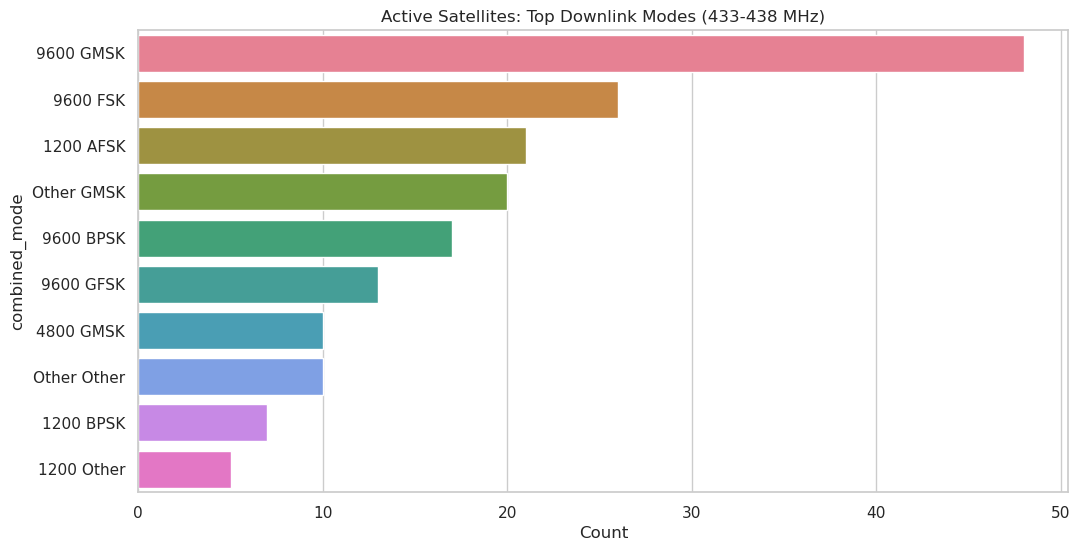

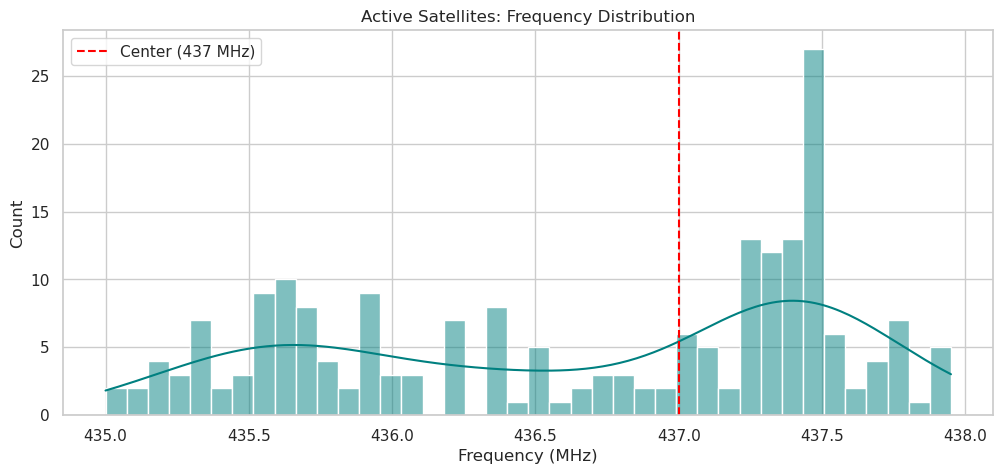

In [6]:
# Top Modes
plt.figure(figsize=(12, 6))
mode_counts = target_band['combined_mode'].value_counts().head(10)
sns.barplot(x=mode_counts.values, y=mode_counts.index, hue=mode_counts.index, legend=False)
plt.title("Active Satellites: Top Downlink Modes (433-438 MHz)")
plt.xlabel("Count")
plt.show()

# Frequency Distribution
plt.figure(figsize=(12, 5))
sns.histplot(target_band['primary_freq'], bins=40, kde=True, color='teal')
plt.title("Active Satellites: Frequency Distribution")
plt.xlabel("Frequency (MHz)")
plt.axvline(437.0, color='red', linestyle='--', label='Center (437 MHz)')
plt.legend()
plt.show()

## 6. The Golden Candidates
We select satellites that are:
1.  **Alive** (Verified by SatNOGS).
2.  **9600 bps** (High data rate).
3.  **GMSK/GFSK/FSK** (Common demodulator).

In [7]:
target_mods = ['9600 GMSK', '9600 GFSK', '9600 FSK']
cohort = target_band[target_band['combined_mode'].isin(target_mods)].sort_values('primary_freq')

# Prioritize those with SatNOGS status 'alive' over 'unknown'
cohort['status_priority'] = cohort['status'].apply(lambda x: 1 if x == 'alive' else 2)
cohort = cohort.sort_values(['status_priority', 'primary_freq'])

print(f"Golden Cohort Size: {len(cohort)}")

cols = ['amsat_name', 'primary_freq', 'mode', 'status', 'norad_cat_id', 'callsign']
print("\nTop Candidates (Confirmed Alive):")
print(cohort[cols].head(20).to_string(index=False))

Golden Cohort Size: 87

Top Candidates (Confirmed Alive):
                 amsat_name  primary_freq                      mode status  norad_cat_id     callsign
                   TigriSat       435.000               9600bps FSK  alive       40043.0       HNATIG
                FalconSAT-3       435.103              9600bps GMSK  alive       30776.0   PFS3-11 12
                     LEDSAT       435.190              9600bps GMSK  alive       49069.0          NaN
         GO-32 (TechSat-1B)       435.225               9600bps FSK  alive       25397.0 4XTECH-11 12
         TechSat-1B (GO-32)       435.225               9600bps FSK  alive       25397.0 4XTECH-11 12
                  GREENCUBE       435.310 0k3/1k2*/2k4*/4k8/9k6 FSK  alive       53106.0          NaN
Xiaoxiang-2 (TY-2 Tianyi-2)       435.350       9k6 GMSK/5Mbps OFDM  alive       43155.0          NaN
Tianyi-2 (TY-2 Xiaoxiang-2)       435.350       9k6 GMSK/5Mbps OFDM  alive       43155.0          NaN
                     TTU

In [8]:
# Export
out_path = DATA_DIR / 'golden_candidates.csv'
cohort[cols].to_csv(out_path, index=False)
print(f"\nSaved {len(cohort)} candidates to {out_path}")


Saved 87 candidates to ../data/golden_candidates.csv
